In [1]:
import os
import numpy as np
import random
import pandas as pd
import pygad
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Dados
df = pd.read_csv('data_per_month.csv')['Total Renewable Energy'].values
window_size = 12

def create_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

def remove_outliers(X, y, threshold=3):
    mask_X = np.all(np.abs(X - np.mean(X, axis=0)) <= threshold * np.std(X, axis=0), axis=1)
    mask_y = np.abs(y - np.mean(y)) <= threshold * np.std(y)
    mask = mask_X & mask_y
    return X[mask], y[mask]

X, y = create_windows(df, window_size)
X, y = remove_outliers(X, y)

train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Criar modelo
def build_model(neurons, dense_layers, optimizer_code):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))
    for _ in range(dense_layers):
        model.add(Dense(neurons, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    optimizer = Adam() if optimizer_code == 0 else RMSprop()
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Função de avaliação
def fitness_func(ga_instance, solution, sol_idx):
    try:
        neurons = int(solution[0])
        dense_layers = int(solution[1])
        optimizer_code = int(solution[2])
        batch_size = int(solution[3])
        epochs = int(solution[4])

        print(f"[FITNESS] Neurons={neurons}, Layers={dense_layers}, Opt={'Adam' if optimizer_code==0 else 'RMSprop'}, Batch={batch_size}, Epochs={epochs}")

        model = build_model(neurons, dense_layers, optimizer_code)
        model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                  epochs=epochs, batch_size=batch_size, verbose=0)

        preds = model.predict(X_val_scaled, verbose=0)
        mse = mean_squared_error(y_val, preds)
        return 1.0 / (mse + 1e-8)
    except Exception as e:
        print(f"[ERRO NA FITNESS] {e}")
        return 0

# Espaço de busca
gene_space = [
    {'low': 8, 'high': 64},     # neurônios
    {'low': 1, 'high': 4},       # número de camadas densas
    {'low': 0, 'high': 1},       # otimizador (0=Adam, 1=RMSprop)
    {'low': 8, 'high': 64},      # batch size
    {'low': 200, 'high': 600}     # épocas
]

# Instância do GA
ga_instance = pygad.GA(
    num_generations=10,
    num_parents_mating=4,
    fitness_func=fitness_func,
    sol_per_pop=10,
    num_genes=len(gene_space),
    gene_space=gene_space,
    parent_selection_type="rank",
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=20,
    on_generation=lambda ga: print(f"Ger {ga.generations_completed} - Melhor fitness: {ga.best_solution()[1]:.6f}")
)

ga_instance.run()

# Melhor solução
solution, fitness, _ = ga_instance.best_solution()
print("\nMelhor conjunto de hiperparâmetros:")
print(f"Neurônios: {int(solution[0])}")
print(f"Camadas densas: {int(solution[1])}")
print(f"Otimizador: {'Adam' if int(solution[2]) == 0 else 'RMSprop'}")
print(f"Batch size: {int(solution[3])}")
print(f"Épocas: {int(solution[4])}")
print(f"Fitness: {fitness}")


[FITNESS] Neurons=13, Layers=3, Opt=Adam, Batch=49, Epochs=442
[FITNESS] Neurons=31, Layers=2, Opt=Adam, Batch=38, Epochs=411
[FITNESS] Neurons=30, Layers=3, Opt=Adam, Batch=62, Epochs=586
[FITNESS] Neurons=17, Layers=1, Opt=Adam, Batch=8, Epochs=206
[FITNESS] Neurons=46, Layers=3, Opt=Adam, Batch=45, Epochs=445
[FITNESS] Neurons=18, Layers=3, Opt=Adam, Batch=20, Epochs=529
[FITNESS] Neurons=45, Layers=1, Opt=Adam, Batch=50, Epochs=551
[FITNESS] Neurons=24, Layers=3, Opt=Adam, Batch=31, Epochs=469
[FITNESS] Neurons=10, Layers=3, Opt=Adam, Batch=35, Epochs=527
[FITNESS] Neurons=45, Layers=2, Opt=Adam, Batch=36, Epochs=488
[FITNESS] Neurons=10, Layers=3, Opt=Adam, Batch=45, Epochs=445
[FITNESS] Neurons=46, Layers=2, Opt=Adam, Batch=45, Epochs=445
[FITNESS] Neurons=46, Layers=3, Opt=Adam, Batch=50, Epochs=551
[FITNESS] Neurons=45, Layers=1, Opt=Adam, Batch=34, Epochs=527
[FITNESS] Neurons=10, Layers=3, Opt=Adam, Batch=44, Epochs=445
[FITNESS] Neurons=46, Layers=3, Opt=Adam, Batch=45, Epoc

Epoch 1/526
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 95966.4688 - mae: 305.9763 - val_loss: 105330.8828 - val_mae: 323.7683
Epoch 2/526
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 95831.9609 - mae: 305.7262 - val_loss: 105237.7656 - val_mae: 323.6240
Epoch 3/526
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 95668.4609 - mae: 305.4204 - val_loss: 105123.4609 - val_mae: 323.4470
Epoch 4/526
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 95466.0781 - mae: 305.0396 - val_loss: 104987.3594 - val_mae: 323.2360
Epoch 5/526
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 95222.5391 - mae: 304.5818 - val_loss: 104827.3359 - val_mae: 322.9876
Epoch 6/526
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 94933.0156 - mae: 304.0363 - val_loss: 104638.7891 - val_mae: 322.6947
Epoch 7/526
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 94589.6641 - mae: 303.3857 - val_loss: 104414.6641 - val_mae: 322.3459
Epoch 8/526
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 94180.0625 - mae: 302.6039 - val_loss: 104148.

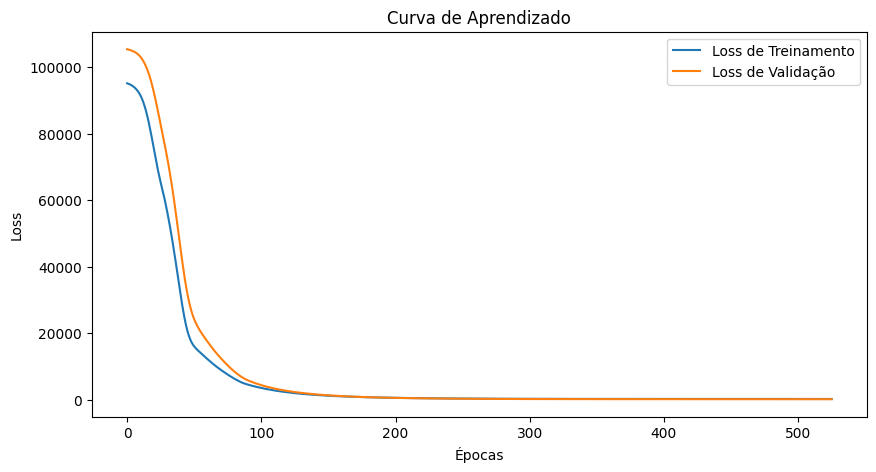

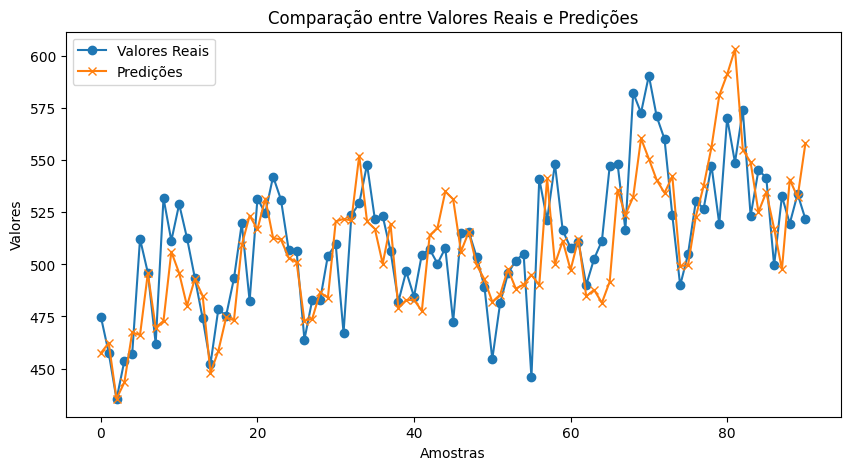

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Garantir reprodutibilidade total
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

# Função para criar o modelo com regularização
def create_model(neurons=10, dropout_rate=0.2, optimizer='adam'):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(neurons, activation='relu'),
        # Dropout(dropout_rate),
        Dense(neurons, activation='relu'),
        Dense(neurons, activation='relu'),
        Dense(1)
    ])
    
    optimizer_instance = Adam() if optimizer == 'adam' else RMSprop()
    model.compile(optimizer=optimizer_instance, loss='mse', metrics=['mae'])
    return model

# Definir manualmente os hiperparâmetros
# dropout_rate = 0.2
optimizer = 'adam'
batch_size = 45
epochs = 526

# Criar e treinar o modelo
model = create_model(optimizer=optimizer)
history = model.fit(X_train_scaled, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)

# Fazer previsões
y_pred = model.predict(X_test_scaled)

# Calcular métricas
eval_results = model.evaluate(X_test_scaled, y_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Loss: {eval_results[0]}, MAE: {eval_results[1]}")
print(f"R²: {r2}, RMSE: {rmse}")

# Plot da curva de aprendizado
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss de Treinamento')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.title('Curva de Aprendizado')
plt.show()

# Comparação entre valores reais e previstos
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Valores Reais', marker='o')
plt.plot(y_pred, label='Predições', marker='x')
plt.xlabel('Amostras')
plt.ylabel('Valores')
plt.legend()
plt.title('Comparação entre Valores Reais e Predições')
plt.show()
